In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [2]:
df=pd.read_csv("../Data.csv",index_col="Date")
df.index=pd.to_datetime(df.index)

In [3]:
close_series = df['Close']


In [4]:
close_series

Date
2015-02-09     26.766184
2015-02-10     27.280405
2015-02-11     27.919817
2015-02-12     28.273066
2015-02-13     28.411680
                 ...    
2025-02-03    228.009995
2025-02-04    232.800003
2025-02-05    232.470001
2025-02-06    233.220001
2025-02-07    227.630005
Name: Close, Length: 2516, dtype: float64

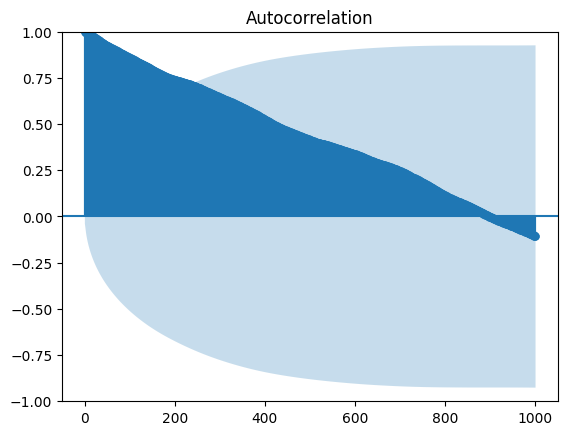

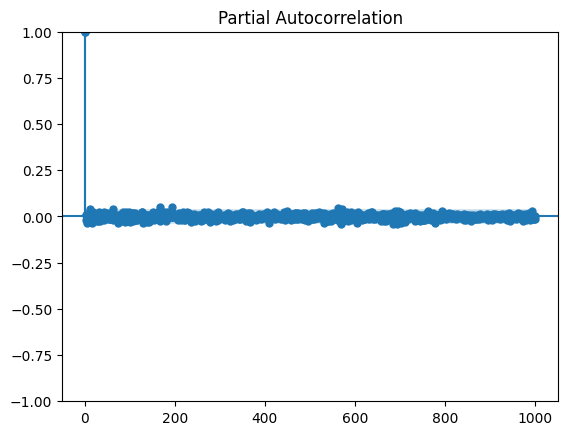

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(close_series, lags=1000)
plt.show()

plot_pacf(close_series, lags=1000)
plt.show()

**Pour ACF** : L'ACF décroît lentement : la série n'est pas stationnaire (d=1 ou plus est nécessaire)

**Pour PACF** : la PACF est très condensée (avec de nombreux pics proches les uns des autres), cela rend  la détermination exacte de p difficile 
**Alors :** utiliser une grid search  est une excellente approche pour trouver les meilleurs paramètres ARIMA (p,d,q)



In [5]:
# 🎯 2. Division Train/Test

train_data=close_series[0:int(len(close_series)*0.8)]
test_data=close_series[int(len(close_series)*0.8):len(close_series)]


In [6]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
def grid_search_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            print(f"model aic: {aic} || best score: {best_score}")
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
        except:  
            continue
    return best_cfg, best_score

In [7]:
import warnings
warnings.filterwarnings("ignore")
#j'ai ajouter ce block de code pour ignorer les warnings 

In [8]:
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

best_cfg, best_score = grid_search_arima(train_data, p_values, d_values, q_values)
print(f"Meilleurs paramètres ARIMA: {best_cfg} avec AIC: {best_score}")

model aic: 21393.179150409433 || best score: inf
model aic: 18697.756440368204 || best score: 21393.179150409433
model aic: 16487.740321063044 || best score: 18697.756440368204
model aic: 14743.86806650993 || best score: 16487.740321063044
model aic: 14850.001290442075 || best score: 14743.86806650993
model aic: 7987.575378736016 || best score: 14743.86806650993
model aic: 7984.02641309214 || best score: 7987.575378736016
model aic: 7984.616354585292 || best score: 7984.02641309214
model aic: 7985.61221731262 || best score: 7984.02641309214
model aic: 7987.478764795498 || best score: 7984.02641309214
model aic: 8002.668706197757 || best score: 7984.02641309214
model aic: 7999.489499533918 || best score: 7984.02641309214
model aic: 8000.356424788152 || best score: 7984.02641309214
model aic: 8001.705205794548 || best score: 7984.02641309214
model aic: 8003.547526944416 || best score: 7984.02641309214
model aic: 7984.322734912398 || best score: 7984.02641309214
model aic: 7984.4422589396

p=2 : Cela signifie que le modèle AR utilise les deux valeurs précédentes de la série pour prédire la valeur actuelle

d=1 : Une différenciation d'ordre 1 a été appliquée pour rendre la série stationnaire.

q=4 : Le modèle MA (Moving Average) utilise les erreurs des quatre périodes précédentes pour ajuster les prévisions.

AIC (Akaike Information Criterion) :

L'AIC est une mesure de la qualité du modèle qui prend en compte à la fois la précision et la complexité du modèle.

Un AIC plus faible indique un meilleur modèle. Ici, 7954.15 est la valeur minimale trouvée parmi toutes les combinaisons testées.

In [9]:
# Validation par glissement (Walk Forward Validation)
history = list(train_data)
predictions = list()
errors=list()
for t in range(len(test_data)):
    model = ARIMA(history, order=best_cfg)  # Utilisation des paramètres optimisés
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_data.iloc[t])  # Mise à jour avec la vraie valeur
    print(f">Predicted=%.3f, Expected=%.3f" % (yhat, test_data.iloc[t]))
    errors.append(test_data.iloc[t]-yhat)

>Predicted=152.549, Expected=150.151
>Predicted=150.241, Expected=153.041
>Predicted=152.688, Expected=150.339
>Predicted=150.750, Expected=149.300
>Predicted=149.499, Expected=149.667
>Predicted=150.033, Expected=152.481
>Predicted=152.326, Expected=151.837
>Predicted=151.853, Expected=153.948
>Predicted=153.902, Expected=152.343
>Predicted=152.415, Expected=151.193
>Predicted=150.835, Expected=147.159
>Predicted=147.407, Expected=147.585
>Predicted=147.677, Expected=148.071
>Predicted=148.062, Expected=145.405
>Predicted=145.536, Expected=146.604
>Predicted=146.500, Expected=146.099
>Predicted=146.470, Expected=144.017
>Predicted=144.527, Expected=144.612
>Predicted=144.670, Expected=149.687
>Predicted=148.971, Expected=152.462
>Predicted=152.111, Expected=150.251
>Predicted=150.607, Expected=151.510
>Predicted=151.475, Expected=149.250
>Predicted=149.044, Expected=147.179
>Predicted=146.929, Expected=149.131
>Predicted=149.335, Expected=151.233
>Predicted=151.441, Expected=151.629
>

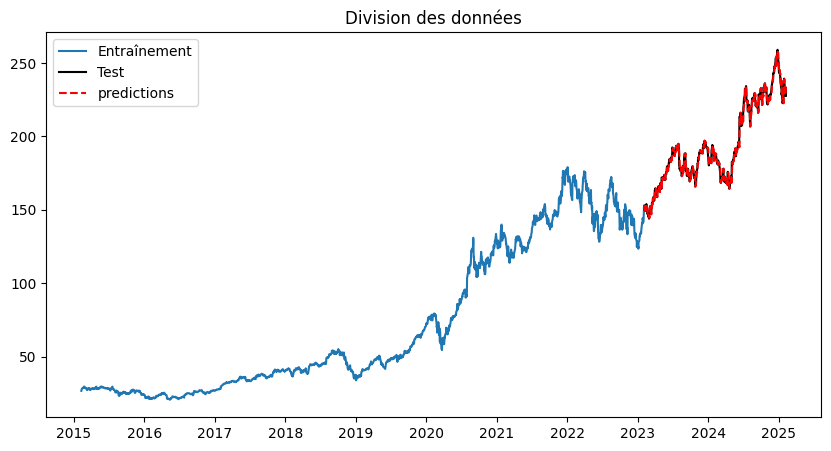

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data.values, label='Entraînement')
plt.plot(test_data.index, test_data.values, label='Test', color='black')
plt.plot(test_data.index, predictions, label='predictions', color='red' , linestyle = "--")
plt.title("Division des données")
plt.legend()
plt.show()

Le modèle ARIMA semble bien performer pour capturer la tendance générale, mais il y a des écarts dans les prédictions on va calculer **rmse**(  mesure l'écart moyen entre les valeurs prédites et les valeurs réelles) pour determiner ces ecarts 

In [11]:
import numpy as np 
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 2.702


In [12]:
errors=np.array(errors)

Text(0.5, 1.0, 'Les erreurs effectuées lors de la prediction')

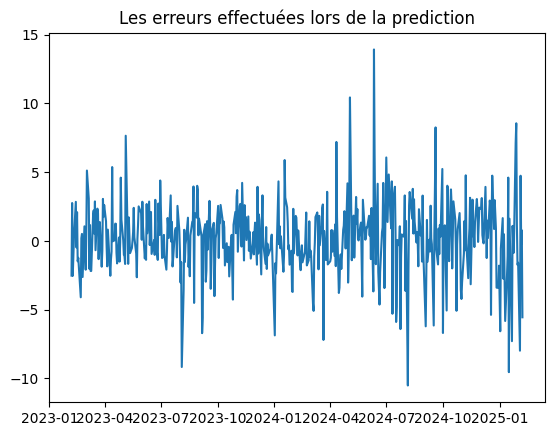

In [16]:
plt.plot(test_data.index,errors)
plt.title("Les erreurs effectuées lors de la prediction")
